## ECE276C Assignment 3: Policy Gradients

by Shivani Bhakta

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt
import pybullet
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical 
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
import time

### Setup Device

In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


#### Function to get plots for all parts of this assignment

In [3]:
def get_plot(avg_return, title): 
    %matplotlib inline
    plt.figure()
    plt.plot(avg_return)
    plt.xlabel('# iterations')
    plt.ylabel('Average Returns')
    plt.title(title)
    plt.show()

### Network Definition 

Here we use a X fully connected neural network layer to estimate policy. We use Adam optimizer. 

In [4]:
class PolicyNet(nn.Module):
    
    def __init__(self, env):
        
        super(PolicyNet,self).__init__()
        
        self.n_states = env.observation_space.shape[0]
        self.n_actions = env.action_space.n
        
        self.l1 = nn.Linear(self.n_states, 48)
        self.dropout = nn.Dropout(p=0.2)
        self.l2 = nn.Linear(48, self.n_actions)
    
    def forward(self, x): 
        model = nn.Sequential(
            self.l1,
            self.dropout,
            nn.ReLU(),
            
            nn.Softmax(dim=-1),
            self.l2,
            nn.Softmax(dim=-1))

        return model(torch.FloatTensor(x).to(device))


In [5]:
def get_action(model, state): 
    
    action_probs = model.forward(state)
    m = Categorical(action_probs)
    action = m.sample()
    log_prob = m.log_prob(action)
    return action.item(), log_prob

### Question 1 - CartPole-v1


### Part 1) 

Here we implement vanilla reinforce algorithm given by the following gradient update for the policy: 

$ \bigtriangledown J(\theta) \approx \frac{1}{n} \sum \limits_{i = 0}^{n}  G(\tau) (\sum \limits_{t=0}^{T}  \bigtriangledown_{\theta}$ log  $\pi_{\theta}(a_{t}|s_{t})) $ 

where $G(\tau) = \sum \limits_{t=0}^{\tau} \gamma^{t} r(t)$ is the Monte Carlo estimate of the discounted return, 

$\pi_{\theta} (a_{t} | s_{t})$ is the probability of taking action $a_{t}$ given $s_{t}$ and $n$ is the number of episodes

In [6]:
def train_vanilla_reinforce(env, model, optimizer, batch_size = 500, epochs = 200, gamma = 0.99): 
 
    """
    Train a model using the vanilla reinforce algorithm.
    
    Inputs:
    - env: gym environment object
    - model: PolicyNet 
    - optimizer: An Optimizer object we will use to train the model
    - batch_size: batch size 
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    - gamma: discount factor for Monte carlo estimate
    
    Returns: Nothing, but prints model accuracies during training.
    """
    
    # List to store step over each episode/trajectory
    avg_reward = []
    
    for e in range(epochs):
        # this is a loop for each trajectory of the pole.
        
        # trackers for each trajectory. 
        traj_reward = []
        traj_logs_prob_total = 0
        
        # trackers for each batch 
        batch_loss = 0
        batch_traj_counter = 0
        batch_rewards = []
        
        state = env.reset()
        done = False
        
        for step in range(batch_size): 
               
            #get next action and state 
            action, log_prob = get_action(model, state)
            state_next, reward, done, info = env.step(action)
            
            #store state/action info
            traj_reward.append(reward)
            traj_logs_prob_total += log_prob 
            
            #check if done
            if done:
                
                # calculate G(t)
                # G(t) = sum gamma**t * r(t)    
#                 temp1 = torch.FloatTensor([gamma ** i for i in range(len(traj_reward))]).to(device)  
#                 temp2  = torch.FloatTensor(traj_reward).to(device)
#                 discounted_return = torch.sum(temp1 * temp2)
                discounted_return = torch.sum(torch.FloatTensor([(gamma ** t)*traj_reward[t] for t in range(len(traj_reward))]))
                
                # gradient update
                batch_loss += discounted_return * traj_logs_prob_total
                
                
                batch_rewards.append(np.sum(traj_reward))
                batch_traj_counter += 1
                                              
                # reset state
                traj_reward = []
                traj_logs_prob_total = 0
                state = env.reset()
                                              
            else: 
                state = state_next
   
        avg_reward.append(np.mean(batch_rewards))
        loss = - batch_loss / batch_traj_counter
#         print('Epoch %d, loss = %.4f, avg_reward: %.4f' % (e, loss.item(), np.mean(batch_rewards) ))

        # update policy parameters 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return avg_reward
        

In [7]:
env = gym.make('CartPole-v1')
env.reset()
model = PolicyNet(env)
optimizer = optim.Adam(model.parameters(), lr=0.01)
avg_return = train_vanilla_reinforce(env, model, optimizer, batch_size = 500, epochs = 200, gamma = 0.99)

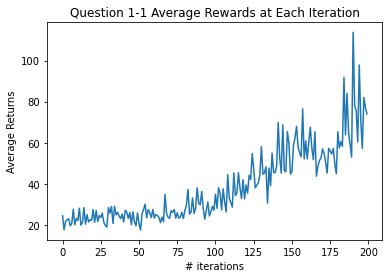

In [8]:
get_plot(avg_return, 'Question 1-1 Average Rewards at Each Iteration')

With the batch size of 500 steps, for 200 iterations, using $\gamma = 0.99$ and $\alpha = 0.01$ learning rate, we get the above average returns. 

The result show that the average reward increases as we train for more iterations. This also means that the gradient update algorithm will eventually converge to a consistant policy.  

### Part 2 

The gradient at step t is only dependent on the future rewards, hence we can modify the policy gradient as follows:

$ \bigtriangledown J(\theta) \approx \frac{1}{n} \sum \limits_{i = 0}^{n} \sum \limits_{t=0}^{T} \bigtriangledown_{\theta} $ log $ \pi_{\theta}(a_{t}|s_{t}) \sum \limits_{t^{\prime} = t}^{T} \gamma^{t^{\prime} - t} r(t^{\prime}))$

Thus, here we implement the policy gradient algorithm using the above update rule.

In [9]:
def vanilla_reinforce_modified_pi_gradient(env, model, optimizer, batch_size = 500,\
                                           epochs = 200, gamma = 0.99, activate_b = False): 
 
    """
    Train a model using the vanilla reinforce algorithm with modified gradient update.
    
    Inputs:
    - env: gym environment object
    - model: PolicyNet 
    - optimizer: An Optimizer object we will use to train the model
    - batch_size: batch size 
    - epochs: A Python integer giving the number of episodes to train for
    - gamma: discount factor for Monte carlo estimate
    - activate_b: flag to activate the b or not (subtrating b)  
    
    Returns: Nothing, but prints model accuracies during training.
    """
    
    # List to store average reward per episode/trajectory in each iteration. 
    avg_reward = []
    
    for e in range(epochs):
        # this is a loop for each trajectory of the pole.
        
        # trackers for each trajectory. 
        traj_reward = []
        traj_logs_prob_total = []
        
        # trackers for each batch 
        batch_traj_counter = 0
        batch_loss = 0
        batch_rewards = []
        batch_logs_prob = []
        batch_discounted_return = []
        
        state = env.reset()
        done = False
        
        for step in range(batch_size): 
               
            #get next action and state 
            action, log_prob = get_action(model, state)
            state_next, reward, done, info = env.step(action)
            
            #store state/action info
            traj_reward.append(reward)
            traj_logs_prob_total.append(log_prob) 
            
            #check if done
            if done:
                
                # calculate G(t)
                # G(t) = sum gamma**t * r(t)    
                discounted_return = [sum([gamma ** (t_prime - t) * traj_reward[t_prime] \
                                          for t_prime in range(t, len(traj_reward))]) \
                                          for t in range(len(traj_reward))]
                
                batch_logs_prob.extend(traj_logs_prob_total)
                batch_discounted_return.extend(discounted_return) 
                
                batch_rewards.append(np.sum(traj_reward))
                batch_traj_counter += 1
                                              
                # reset state
                traj_reward = []
                traj_logs_prob_total = []
                state = env.reset()
                                              
            else: 
                state = state_next
        
        if activate_b:
            b = np.mean(discounted_return) # such that mean of the modified returns is 0
            batch_discounted_return -=  np.mean(discounted_return)
   
        for step in range(len(batch_logs_prob)):
            batch_loss += batch_logs_prob[step] * batch_discounted_return[step]
        
        
        avg_reward.append(np.mean(batch_rewards))
        loss = - batch_loss / batch_traj_counter
        
#         print('Epoch %d, loss = %.4f, avg_reward: %.4f' % (e, loss.item(), np.mean(batch_rewards) ))

        # update policy parameters 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return avg_reward

In [10]:
env = gym.make('CartPole-v1')
env.reset()
model = PolicyNet(env)
optimizer = optim.Adam(model.parameters(), lr=0.01)
avg_return = vanilla_reinforce_modified_pi_gradient(env, model, optimizer, batch_size = 500, \
                                                    epochs = 200, gamma = 0.99, activate_b = False)

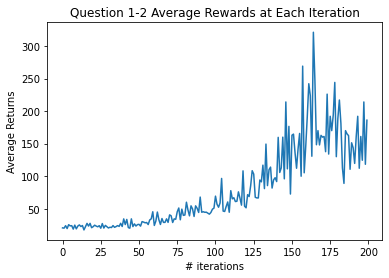

In [11]:
get_plot(avg_return, 'Question 1-2 Average Rewards at Each Iteration')

After using the modified vanilla reinforce algorithm with the new gradient update, we get the above result with the same batch size = 500, for 200 iterations and $\gamma = 0.99$ and $\alpha = 0.01$. 

As we can tell form the plot, it is much better than Question 1.1. As expected, the gradient at step $t$ is only dependent on the future rewards, hence the modified policy gradient gives us better results. Thus it will converge faster than Question 1.1  

### Part 3

The gradient at step t is only dependent on the future rewards, hence we can modify the policy gradient as follows:

$ \bigtriangledown J(\theta) \approx \frac{1}{n} \sum \limits_{i = 0}^{n} \sum \limits_{t=0}^{T} \bigtriangledown_{\theta} $ log $ \pi_{\theta}(a_{t}|s_{t}) \sum \limits_{t^{\prime} = t}^{T} (\gamma^{t^{\prime} - t} r(t^{\prime})) - b )$

Thus, here we implement the policy gradient algorithm using the above update rule.

In [12]:
env = gym.make('CartPole-v1')
env.reset()
model = PolicyNet(env)
optimizer = optim.Adam(model.parameters(), lr=0.01)
avg_return = vanilla_reinforce_modified_pi_gradient(env, model, optimizer, batch_size = 500, \
                                                    epochs = 200, gamma = 0.99, activate_b = True)

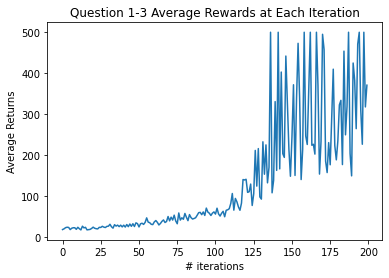

In [13]:
get_plot(avg_return, 'Question 1-3 Average Rewards at Each Iteration')

This past we use the modified vanilla reinforce algorithm with baseline $b$. To reduce the variance of the estimated returns, We use $b$ such that the mean of the modified returns is 0. Hence $b$ would turn out to be the mean of the total batch return, and we subtract it, so the mean of the modified returns will be 0. 

The baseline method gives us better results than both Question 1.1 and Question 1.2. From the results above we can see that it converges faster and gives us higher rewards in lower number of iterations. Which is gives higher results in last few batches. 

### Part 4: Train Policy with the update in question 1.3 with different batch sizes for 200 iterations. 

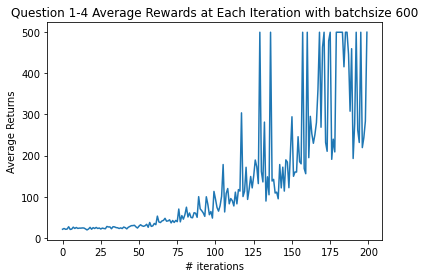

In [14]:
avg_return_list = []
env = gym.make('CartPole-v1')
env.reset()
model = PolicyNet(env)
optimizer = optim.Adam(model.parameters(), lr=0.01)
avg_return = vanilla_reinforce_modified_pi_gradient(env, model, optimizer, batch_size = 600, \
                                                 epochs = 200, gamma = 0.99, activate_b = True)
get_plot(avg_return, 'Question 1-4 Average Rewards at Each Iteration with batchsize 600')
avg_return_list.append(avg_return)

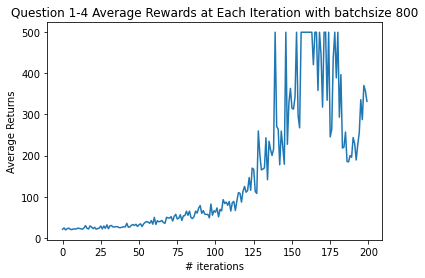

In [15]:
env = gym.make('CartPole-v1')
env.reset()
model = PolicyNet(env)
optimizer = optim.Adam(model.parameters(), lr=0.01)
avg_return = vanilla_reinforce_modified_pi_gradient(env, model, optimizer, batch_size = 800, \
                                                 epochs = 200, gamma = 0.99, activate_b = True)
get_plot(avg_return, 'Question 1-4 Average Rewards at Each Iteration with batchsize 800')
avg_return_list.append(avg_return)

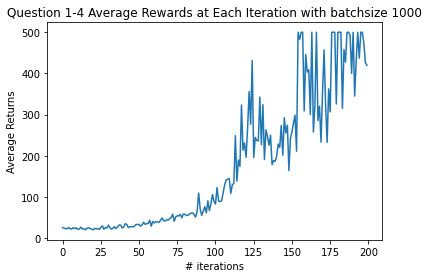

In [16]:
env = gym.make('CartPole-v1')
env.reset()
model = PolicyNet(env)
optimizer = optim.Adam(model.parameters(), lr=0.01)
avg_return = vanilla_reinforce_modified_pi_gradient(env, model, optimizer, batch_size = 1000, \
                                                 epochs = 200, gamma = 0.99, activate_b = True)
get_plot(avg_return, 'Question 1-4 Average Rewards at Each Iteration with batchsize 1000')
avg_return_list.append(avg_return)

### All three plot in one for comparision 

From the above results, we can see that the results for average rewards improves as we increase the batch size. It starts giving us higher average sooner for higher batch size. 

This is what we expected as we know that reinforcement algorithm works better with more data. 

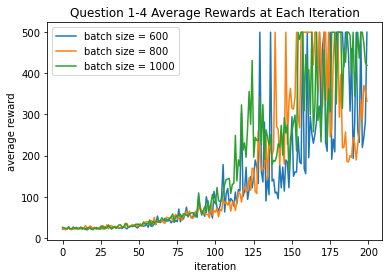

In [17]:
%matplotlib inline
plt.figure()
for r in avg_return_list:
    plt.plot(r)
plt.xlabel('iteration')
plt.ylabel('average reward')
plt.legend(['batch size = ' + str(batch_size) for batch_size in [600, 800, 1000]])
plt.title('Question 1-4 Average Rewards at Each Iteration')
plt.show()